### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 2

**Student Name:**    Zixin Hao

**Student ID:**     

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [1]:
# For an environment bug (just in case) - OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

np.random.seed(108)
tf.random.set_seed(108)
random.seed(108)

from keras.preprocessing.image import ImageDataGenerator

data_dir = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 15
epoch_num = 70

# Data generator for training
# Additional data augmentation may be added here if desired
train_datagen = ImageDataGenerator(
        rescale=1./255,
        # Additional data augmentation
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8,1.2],
)

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
        rescale=1./255,
)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir+'/valid',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir+'/test',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)

# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


#### 1.1 CNN network model implementation

In [2]:
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import Sequential
import matplotlib.pyplot as plt


class SceneClassifier:
        def __init__(self, input_shape=(32, 32, 3)):
                self.model = self._build_model(input_shape)
                self.history = None
                # set early stopping criteria
                self.early_stopping = EarlyStopping(monitor='val_loss',  # monitoring validation loss
                                               patience=10,  # if the validation loss does not decrease in 10 epochs, stop training
                                               restore_best_weights=True)  # recover the weights from the epoch with the lowest validation loss

        def _build_model(self, input_shape):
                model = Sequential()

                # add Convolutional layers
                model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='valid'))
                model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid'))

                # add MaxPooling layer
                model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

                # add full connection layers
                model.add(Flatten())
                model.add(Dense(64, activation='relu'))
                model.add(Dense(8, activation='softmax'))

                return model

        def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
                self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        def train(self, train_data, val_data, batch_size, epochs=epoch_num):
                self.history = self.model.fit(train_data,
                                              validation_data=val_data,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              callbacks=[self.early_stopping])
                return self.history

        def predict(self, x):
                return self.model.predict(x)

        def evaluate(self, test_data):
                return self.model.evaluate(test_data)

        def summary(self):
                return self.model.summary()

        def history_accuracy_plot(self):
                # check if the model has been trained
                if self.history is None:
                        print('No history found, please train the model first.')
                        return
                # plot accuracy
                plt.plot(self.history.history['accuracy'], label='Train')
                plt.plot(self.history.history['val_accuracy'], label='Validation')
                plt.ylabel('Accuracy')
                plt.xlabel('Epoch')
                plt.title('Training and validating accuracy')
                plt.legend()
                plt.savefig('accuracy2.png')
                plt.show()


        def history_loss_plot(self):
                # check if the model has been trained
                if self.history is None:
                        print('No history found, please train the model first.')
                        return
                # plot loss
                plt.plot(self.history.history['loss'], label='Train')
                plt.plot(self.history.history['val_loss'], label='Validation')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.title('Training and validating loss')
                plt.legend()
                plt.savefig('loss2.png')
                plt.show()


#### 1.2 Other helper code for report

In [3]:
classifier = SceneClassifier()
classifier.compile()
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                200768    
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                        

In [4]:
train_history = classifier.train(train_data, val_data, batch_size)

Epoch 1/70
96/96 [==============================] - 8s 78ms/step - loss: 1.9223 - accuracy: 0.2521 - val_loss: 1.6726 - val_accuracy: 0.3781
Epoch 2/70
96/96 [==============================] - 8s 82ms/step - loss: 1.5203 - accuracy: 0.4674 - val_loss: 1.3735 - val_accuracy: 0.4906
Epoch 3/70
96/96 [==============================] - 7s 74ms/step - loss: 1.3345 - accuracy: 0.5507 - val_loss: 1.1976 - val_accuracy: 0.5750
Epoch 4/70
96/96 [==============================] - 7s 76ms/step - loss: 1.1725 - accuracy: 0.5972 - val_loss: 1.0604 - val_accuracy: 0.6469
Epoch 5/70
96/96 [==============================] - 7s 76ms/step - loss: 1.0537 - accuracy: 0.6368 - val_loss: 1.1248 - val_accuracy: 0.5906
Epoch 6/70
96/96 [==============================] - 7s 76ms/step - loss: 0.9815 - accuracy: 0.6451 - val_loss: 0.9829 - val_accuracy: 0.6687
Epoch 7/70
96/96 [==============================] - 8s 79ms/step - loss: 0.9215 - accuracy: 0.6778 - val_loss: 0.9822 - val_accuracy: 0.6781
Epoch 8/70
96

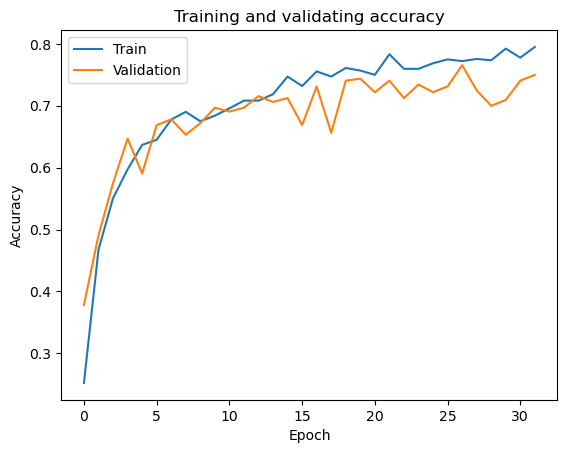

In [5]:
classifier.history_accuracy_plot()

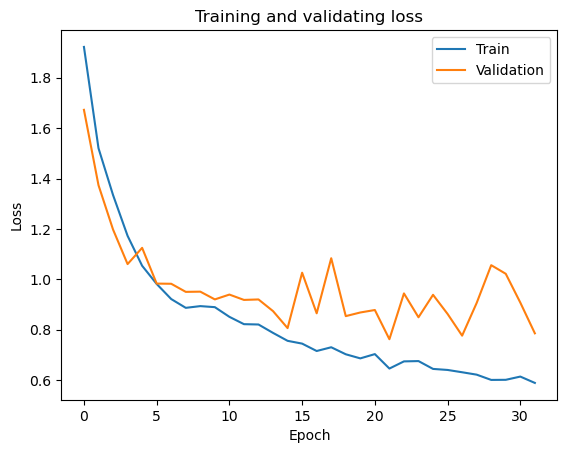

In [6]:
classifier.history_loss_plot()

In [7]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy = classifier.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

22/22 [==============================] - 0s 13ms/step - loss: 0.6626 - accuracy: 0.8000
Test Loss: 0.6626192927360535
Test Accuracy: 0.800000011920929


### 2. Error anaylsis

In [8]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy = classifier.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

22/22 [==============================] - 0s 6ms/step - loss: 0.6626 - accuracy: 0.8000
Test Loss: 0.6626192927360535
Test Accuracy: 0.800000011920929


In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predicted labels
true_labels = test_data.classes
predictions = classifier.predict(test_data)  # output is an array of probabilities
predicted_labels = np.argmax(predictions, axis=1)  # so we have to filter out the class with highest probability, axis = 1 means along the row

def calculate_class_accuracies(true_labels, predicted_labels, class_names):
    """
    Calculate the accuracy for each class and the average accuracy.

    Parameters:
    - true_labels: Array of true labels
    - predicted_labels: Array of predicted labels
    - class_names: List or keys of a dictionary containing class names

    Returns:
    - class_accuracies: Dictionary containing accuracy for each class
    - average_accuracy: Average accuracy across all classes
    """

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Initialize a dictionary to store the accuracy for each class
    class_accuracies = {}

    # Calculate the accuracy for each class
    for i, class_name in enumerate(class_names):
        # The diagonal value is the number of correct classifications for each class
        true_positive = cm[i, i]

        # Calculate the total number of samples for each class
        total = np.sum(cm[i, :])

        # Calculate the accuracy and add it to the dictionary
        accuracy = true_positive / total
        class_accuracies[class_name] = accuracy

    # Calculate the average accuracy
    average_accuracy = np.mean(list(class_accuracies.values()))

    return class_accuracies, average_accuracy

class_accuracies, average_accuracy = calculate_class_accuracies(true_labels, predicted_labels, class_names_and_indices.keys())
print('Class accuracies:')
for class_name, accuracy in class_accuracies.items():
    print('%s: %.4f' % (class_name, accuracy))
print('Average accuracy: %.4f' % average_accuracy)

# print recall and precision
print(classification_report(true_labels, predicted_labels, target_names=class_names_and_indices.keys()))



22/22 [==============================] - 0s 10ms/step
Class accuracies:
coast: 0.8500
forest: 0.8250
highway: 0.8250
insidecity: 0.8000
mountain: 0.7000
opencountry: 0.7750
street: 0.8000
tallbuilding: 0.8250
Average accuracy: 0.8000
              precision    recall  f1-score   support

       coast       0.85      0.85      0.85        40
      forest       0.77      0.82      0.80        40
     highway       0.92      0.82      0.87        40
  insidecity       0.71      0.80      0.75        40
    mountain       0.70      0.70      0.70        40
 opencountry       0.78      0.78      0.78        40
      street       0.82      0.80      0.81        40
tallbuilding       0.89      0.82      0.86        40

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320



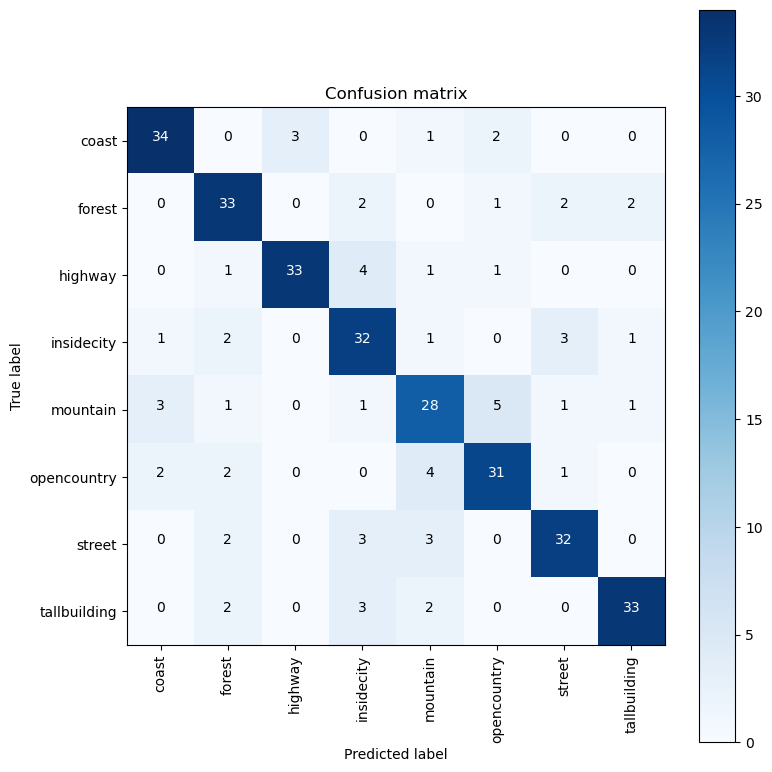

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(true_labels, predicted_labels)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        cm: confusion matrix
        """
        plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j],
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        # plt.savefig('confusion_matrix2.png')

plot_confusion_matrix(cm, classes=class_names_and_indices.keys(), title='Confusion matrix')

Found 64 misclassified examples
Class coast: 6
Class forest: 7
Class highway: 7
Class insidecity: 8
Class mountain: 12
Class opencountry: 9
Class street: 8
Class tallbuilding: 7
[  1   7  10  12  24  32  55  63  67  68  70  74  75  81  82  83  84 117
 118 119 121 138 139 142 143 148 155 158 170 173 177 178 179 180 181 182
 184 192 193 199 205 208 211 214 220 230 231 233 235 241 242 243 253 254
 257 275 279 282 286 296 298 307 309 319]


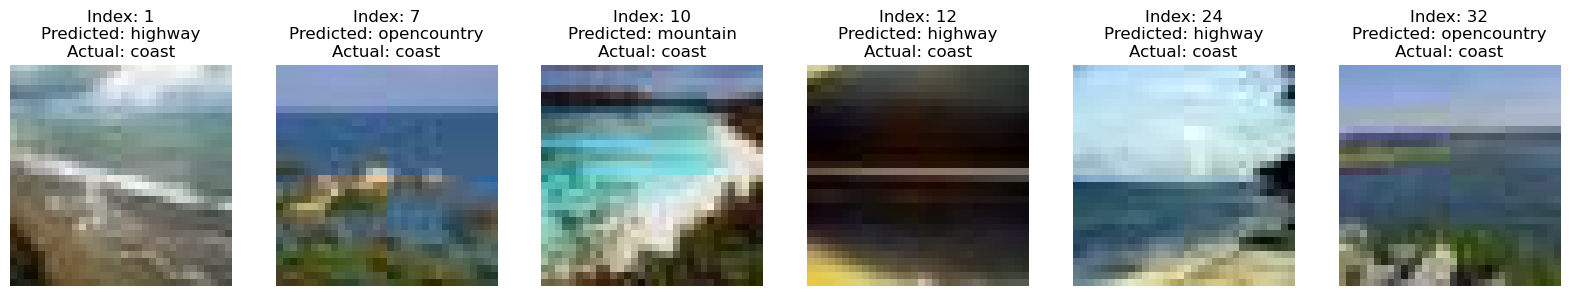

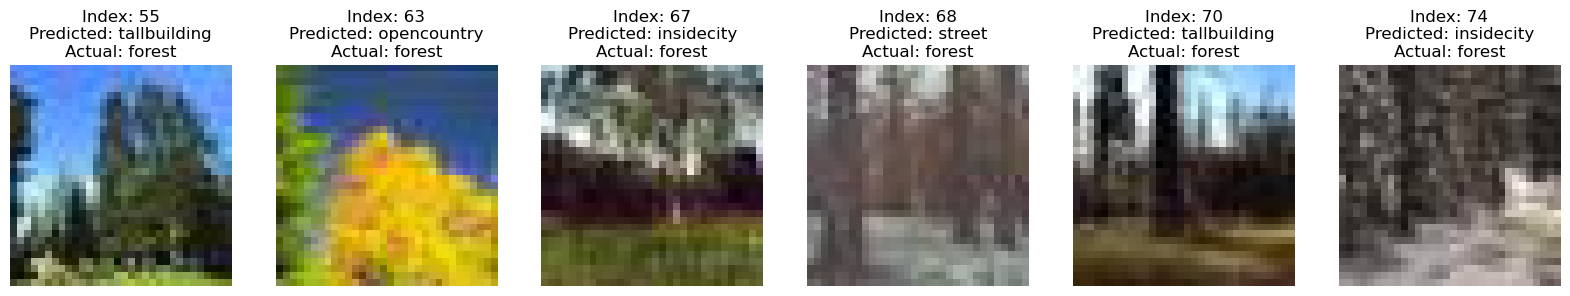

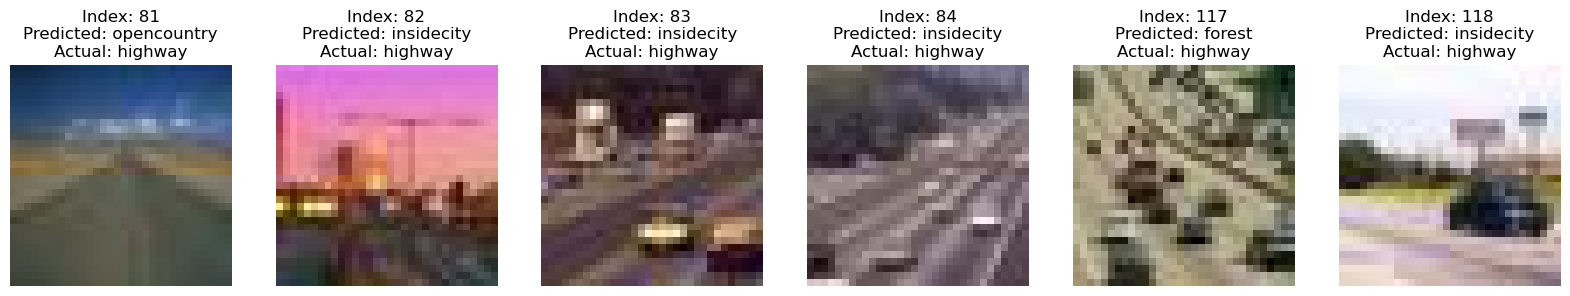

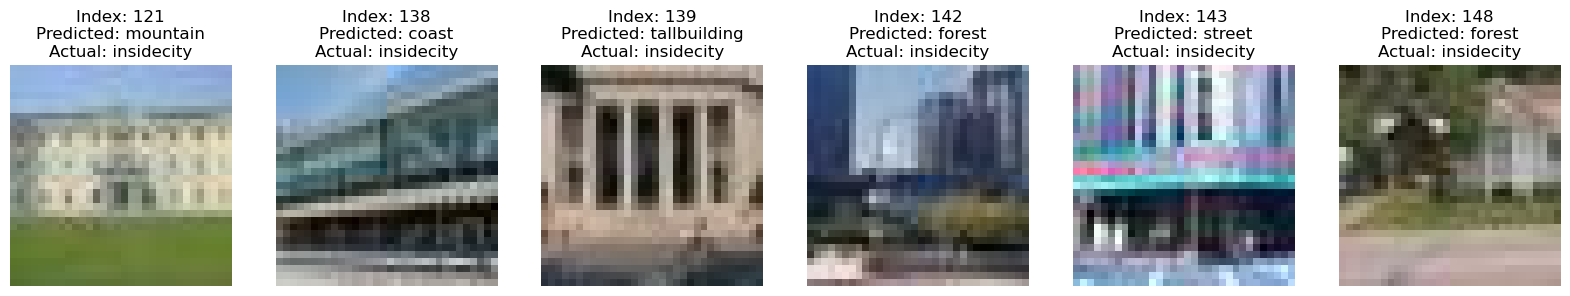

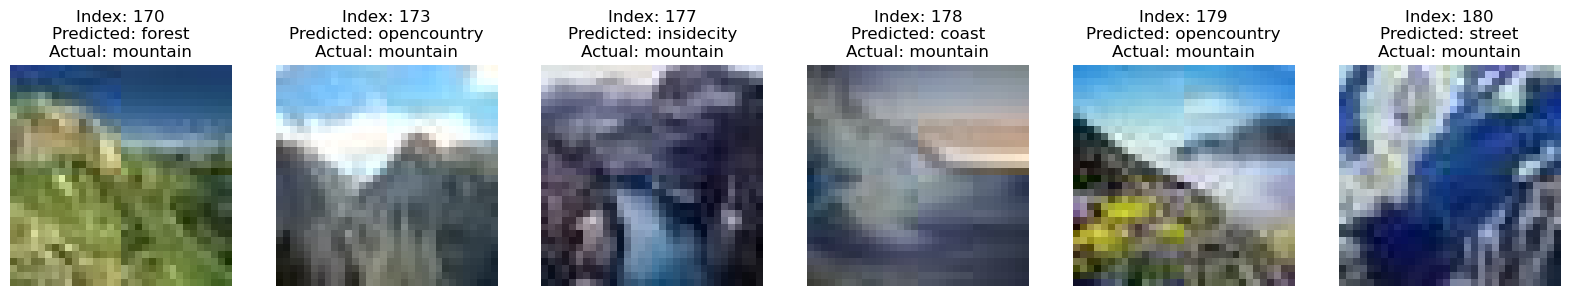

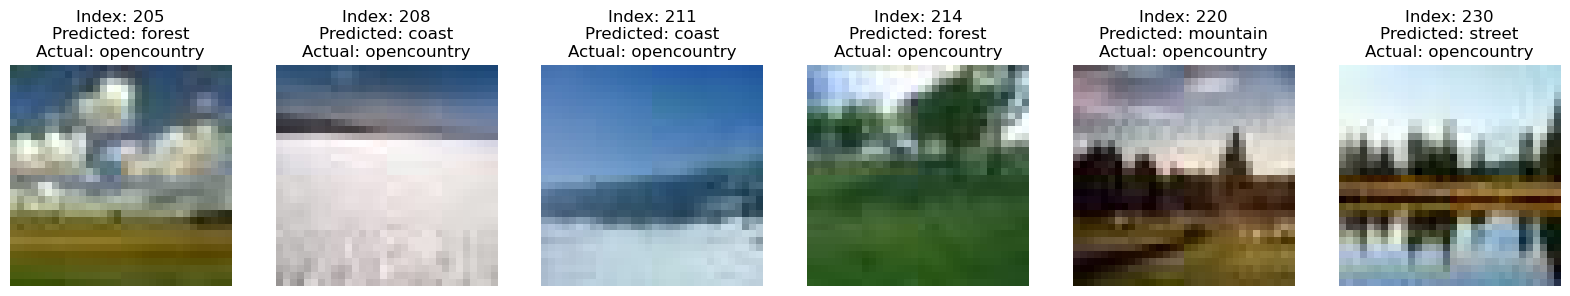

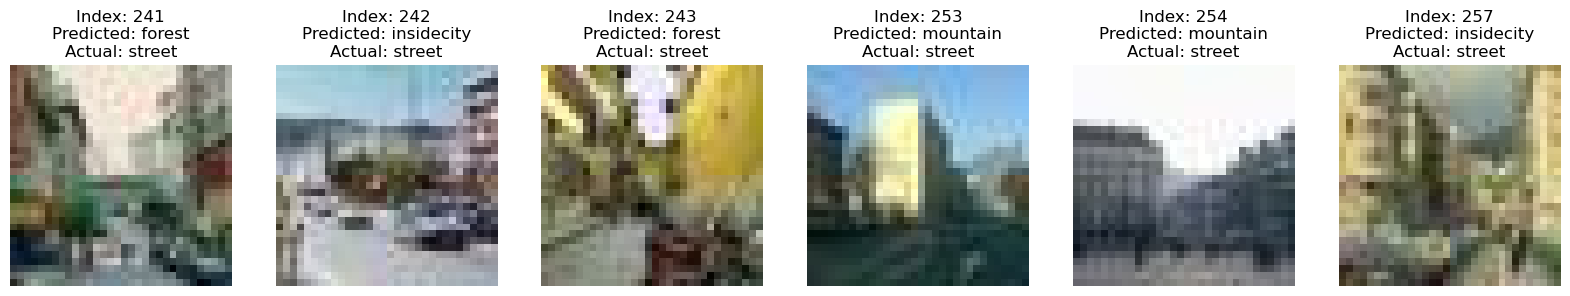

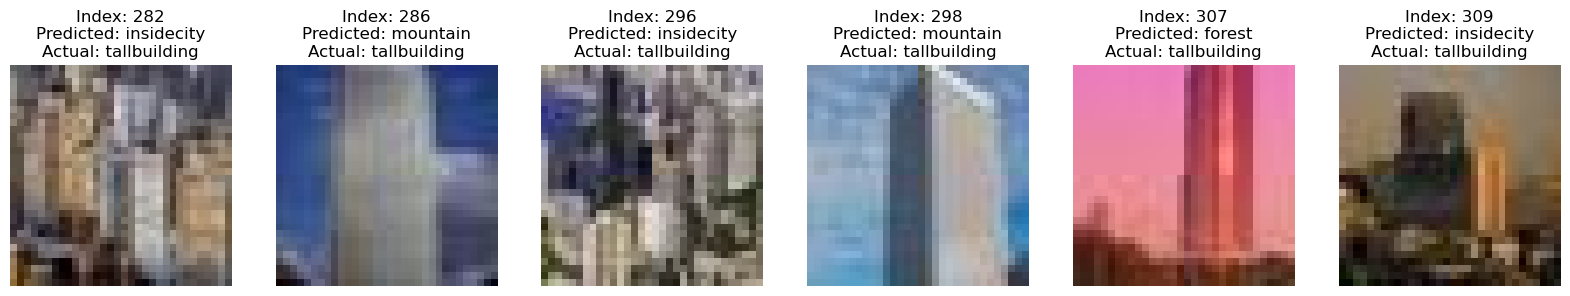

In [11]:
def get_all_misclassified_images(test_data, misclassified_idx):
        """
        The function returns all misclassified images and their corresponding labels
        :param test_data: the test data generator
        :param misclassified_idx: a list of the indices of the misclassified images
        :return: misclassified images
        """
        # reset the generator, so we can iterate over it from the start
        test_data.reset()

        # Because we already know we have 8 classes in test dataset, each class has 40 images.
        # So we can identify the class of each image by its index. Then we display 3 images for each class.
        # {'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}
        misclassified_images = [[], [], [], [], [], [], [], []]

        # Go through all the batches of the generator
        for i, batch in enumerate(test_data):
                temp_images = []
                images, labels = batch
                batch_start = i * test_data.batch_size
                batch_end = (i + 1) * test_data.batch_size

                # Find the indices of the images that are misclassified
                current_indices = [index for index in misclassified_idx if batch_start <= index < batch_end]


                if not current_indices:
                        continue

                relative_indices = [index - batch_start for index in current_indices]
                temp_images.extend(images[relative_indices])
                # add misclassified images to corresponding class
                for j in range(len(current_indices)):
                        misclassified_images[current_indices[j] // 40].append((temp_images[j],current_indices[j]))

                # count how many misclassified images we have already got for each class and stop when all images are found
                misclassified_images_count = [len(misclassified_images[i]) for i in range(len(misclassified_images))]
                if  len(misclassified_idx) == sum(misclassified_images_count):
                        break
        return misclassified_images

def plot_misclassified_examples_for_each_class(misclassified_images, predicted_labels=predicted_labels, class_names_and_indices=class_names_and_indices):
        """
        The function plots misclassified image examples for each class.
        """
        # plot 3 misclassified images as example for each class
        for i in range(len(misclassified_images)):
                plt.figure(figsize=(20, 4))
                for j in range(6):
                        try:
                                ax = plt.subplot(1, 6, j + 1)
                                plt.imshow(misclassified_images[i][j][0])
                                plt.title('Index: %s\nPredicted: %s\nActual: %s' % (
                                        misclassified_images[i][j][1],
                                        list(class_names_and_indices.keys())[predicted_labels[misclassified_images[i][j][1]]],
                                        list(class_names_and_indices.keys())[i]
                                ))
                                plt.axis('off')
                        except:
                                break
                plt.show()


# Find misclassified examples
misclassified_idx = np.where(predicted_labels != true_labels)[0]
misclassified_images = get_all_misclassified_images(test_data, misclassified_idx)
nums_for_each_class = [len(misclassified_images[i]) for i in range(len(misclassified_images))]
count = sum(nums_for_each_class)
print('Found %d misclassified examples' % count)

# show how many misclassified images we have for each class
class_labels = list(test_data.class_indices.keys())
for i in range(len(class_labels)):
        print('Class %s: %d' % (class_labels[i], nums_for_each_class[i]))

print(misclassified_idx)

plot_misclassified_examples_for_each_class(misclassified_images)



### 3. Kernel engineering

#### 3.1 Modify the network

In [12]:
class NewSceneClassifier:
        def __init__(self, kernel_size):
                self.model = self._build_model(kernel_size)
                self.history = None
                # set early stopping criteria
                self.early_stopping = EarlyStopping(monitor='val_loss',  # monitoring validation loss
                                               patience=10,  # if the validation loss does not decrease in 10 epochs, stop training
                                               restore_best_weights=True)  # recover the weights from the epoch with the lowest validation loss

        def _build_model(self, kernel_size):
                model = Sequential()

                # add Convolutional layers
                model.add(Conv2D(16, kernel_size=kernel_size, activation='relu', input_shape=(32, 32, 3), padding='valid'))

                # add MaxPooling layer
                model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

                # add full connection layers
                model.add(Flatten())
                model.add(Dense(64, activation='relu'))
                model.add(Dense(8, activation='softmax'))

                return model

        def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
                self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        def train(self, train_data, val_data, batch_size, epochs=epoch_num):
                self.history = self.model.fit(train_data,
                                              validation_data=val_data,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              callbacks=[self.early_stopping])
                return self.history

        def predict(self, x):
                return self.model.predict(x)

        def evaluate(self, test_data):
                return self.model.evaluate(test_data)
        def summary(self):
                return self.model.summary()

        def helper_for_visualize_kernel(self):
                # Extract the weights from the first convolutional layer
                weights = self.model.layers[0].get_weights()[0]

                # Normalize the weights for better visualization
                weights_min = weights.min()
                weights_max = weights.max()
                weights = (weights - weights_min) / (weights_max - weights_min)
                return weights

#### 3.2 Train and Test

In [13]:


K = [3,4,5,6,7]
def test_for_one_kernel(kernel_size):
        """
        This function trains and evaluates the model for one kernel size
        :param kernel_size:
        :return:
        """
        classifier2 = NewSceneClassifier(kernel_size)
        classifier2.compile()
        classifier2.train(train_data, val_data, batch_size)

        true_labels2 = test_data.classes
        predictions2 = classifier2.predict(test_data)
        predicted_labels2 = np.argmax(predictions2, axis=1)
        class_accuracies2, average_accuracy2 = calculate_class_accuracies(true_labels2,
                                                                        predicted_labels2,
                                                                        class_names_and_indices.keys())
        test_loss, test_accuracy = classifier.evaluate(test_data)
        weights = classifier2.helper_for_visualize_kernel()

        # Extract the output of the first convolutional layer
        conv_layer = classifier2.model.layers[0]
        conv_model = Model(inputs=classifier2.model.inputs, outputs=conv_layer.output)

        return class_accuracies2, average_accuracy2, test_loss, weights, conv_model

def plot_acc_by_different_K(K,result):
        """
        This function plots the accuracy by different K
        :return:
        """
        plt.plot(K, [result[i][2] for i in range(len(result))])
        plt.xlabel('K')
        plt.ylabel('Accuracy')
        plt.title('Average Accuracy by different K')
        plt.xticks(K)
        # plt.savefig('accuracy_by_different_K.png')
        plt.show()

def plot_acc_by_K_for_different_classes(K,result):
        """
        This function plots the accuracy by K for different classes
        :param K:
        :param result:
        :return:
        """
        plt.figure(figsize=(15, 15))

        for i in range(8):
            plt.subplot(4, 2, i+1)
            plt.plot(K, [result[j][1][list(class_names_and_indices.keys())[i]] for j in range(len(result))])
            plt.xlabel('K')
            plt.ylabel('Accuracy')
            plt.title('Accuracy by K for class %s' % list(class_names_and_indices.keys())[i])
            plt.xticks(K)

        plt.tight_layout()
        # plt.savefig('accuracy_by_K_for_all_classes.png')
        plt.show()


In [14]:
result = []
for k in K:
        class_accuracies2, average_accuracy2, test_loss2, weights, conv_model = test_for_one_kernel((k,k))
        result.append(((k,k), class_accuracies2, average_accuracy2, test_loss2, weights, conv_model))

Epoch 1/70
96/96 [==============================] - 3s 30ms/step - loss: 1.8265 - accuracy: 0.3014 - val_loss: 1.6953 - val_accuracy: 0.3375
Epoch 2/70
96/96 [==============================] - 3s 34ms/step - loss: 1.5156 - accuracy: 0.4674 - val_loss: 1.4589 - val_accuracy: 0.5063
Epoch 3/70
96/96 [==============================] - 4s 41ms/step - loss: 1.3936 - accuracy: 0.5236 - val_loss: 1.5414 - val_accuracy: 0.4375
Epoch 4/70
96/96 [==============================] - 3s 31ms/step - loss: 1.3164 - accuracy: 0.5479 - val_loss: 1.3115 - val_accuracy: 0.5375
Epoch 5/70
96/96 [==============================] - 3s 29ms/step - loss: 1.2909 - accuracy: 0.5514 - val_loss: 1.2492 - val_accuracy: 0.5437
Epoch 6/70
96/96 [==============================] - 3s 34ms/step - loss: 1.2207 - accuracy: 0.5910 - val_loss: 1.1615 - val_accuracy: 0.5844
Epoch 7/70
96/96 [==============================] - 4s 38ms/step - loss: 1.1604 - accuracy: 0.6035 - val_loss: 1.2026 - val_accuracy: 0.5656
Epoch 8/70
96

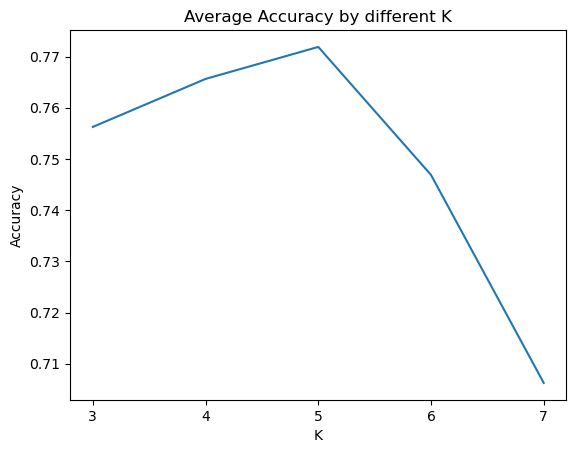

In [15]:
plot_acc_by_different_K(K, result)

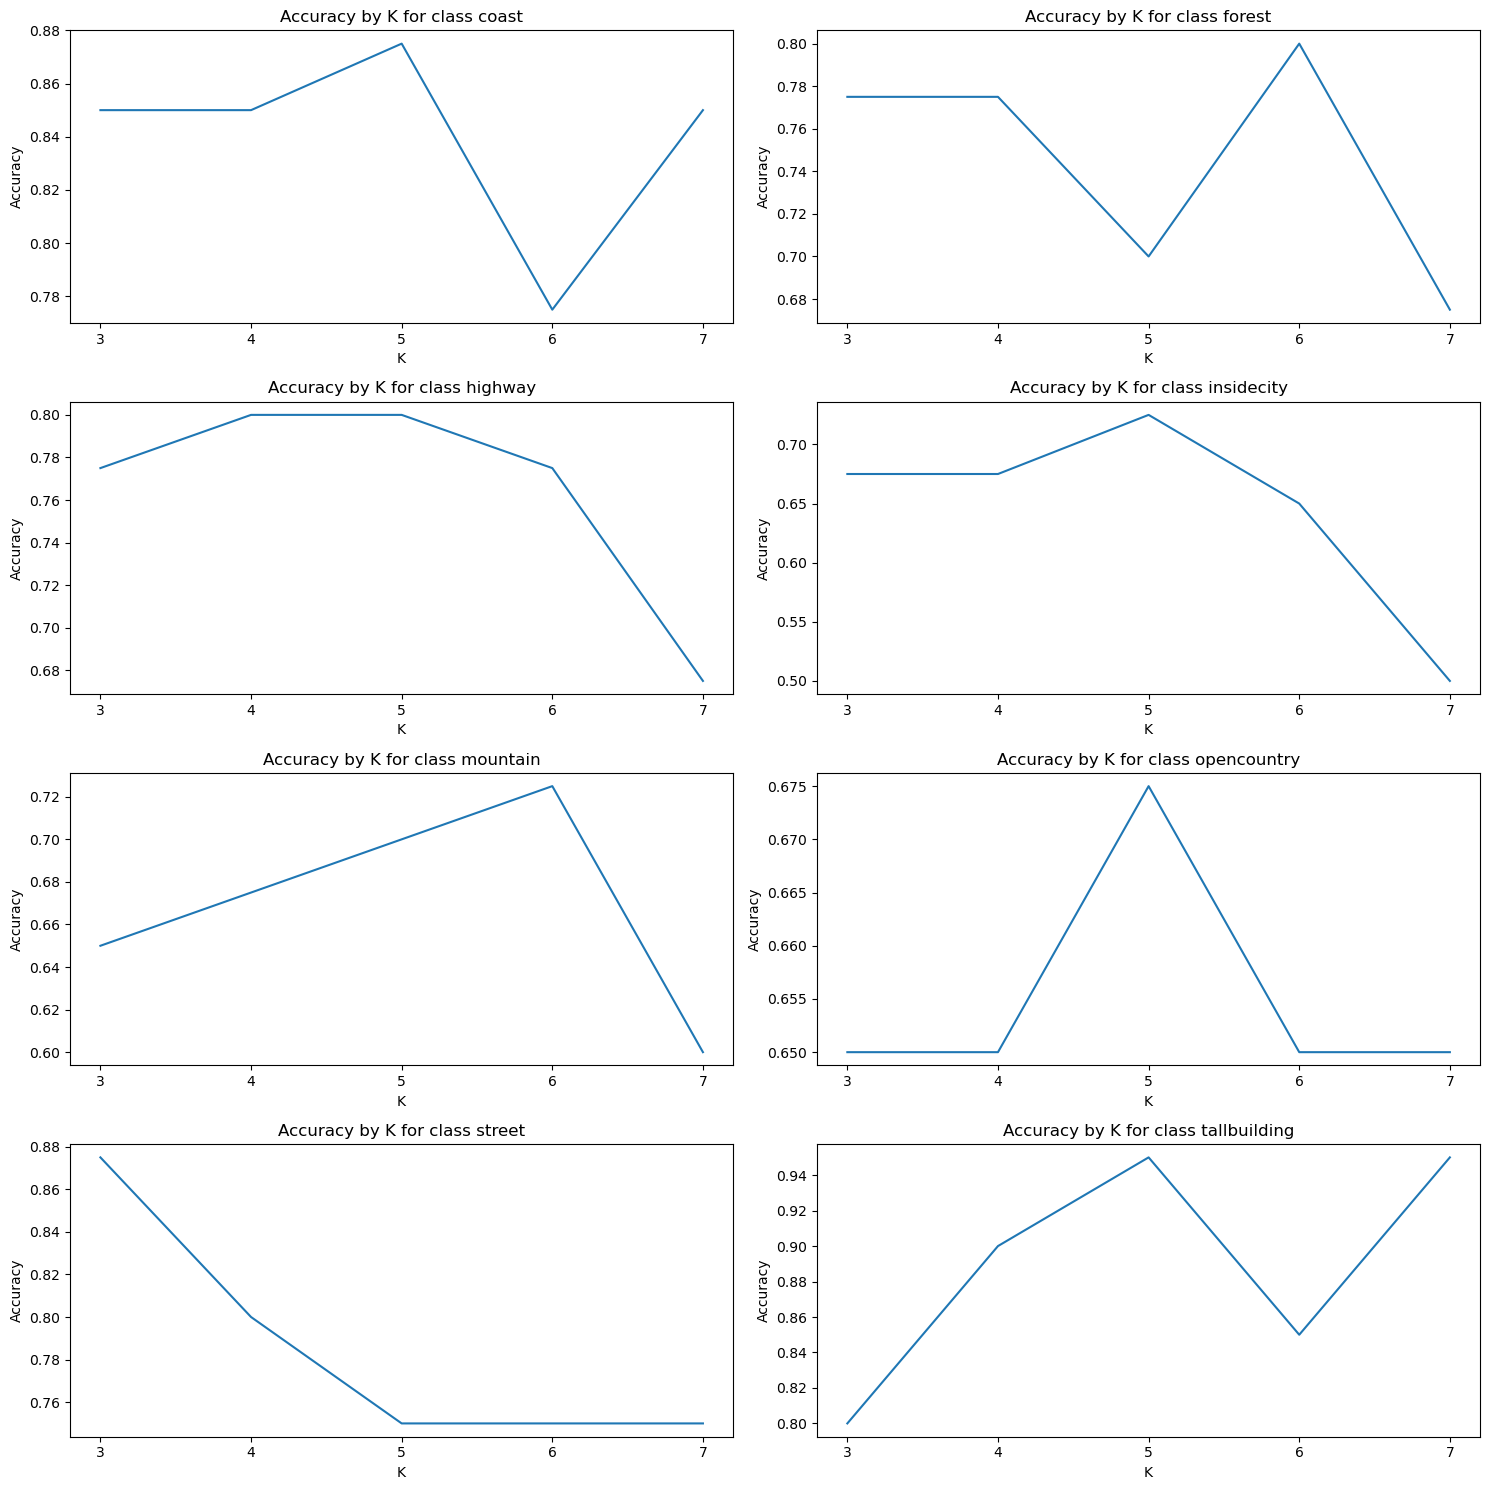

In [16]:
plot_acc_by_K_for_different_classes(K, result)

#### 3.3 Visualize the kernel

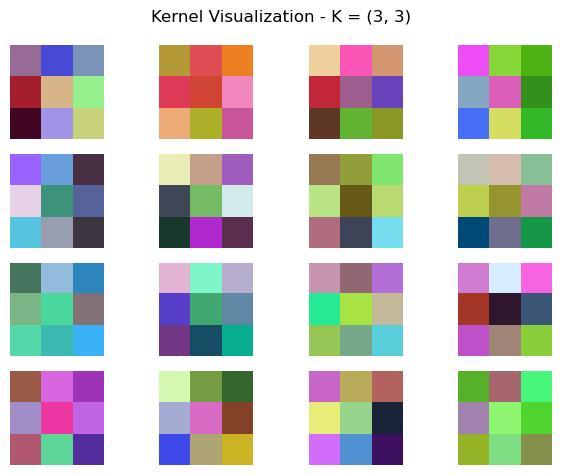

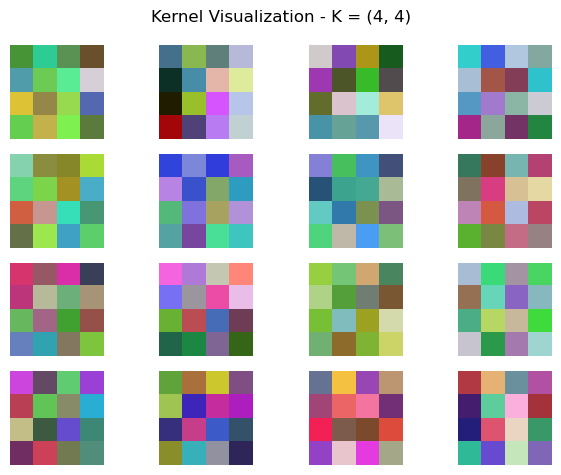

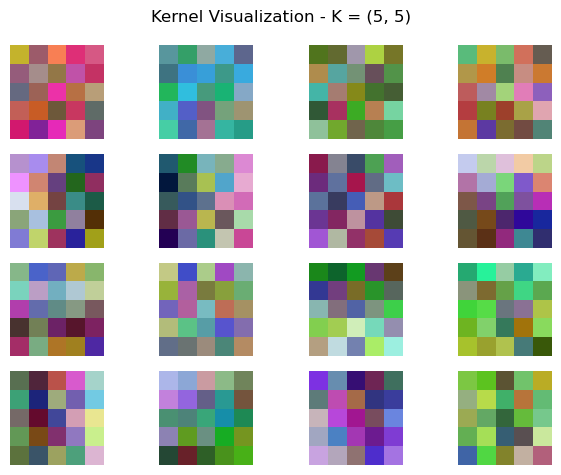

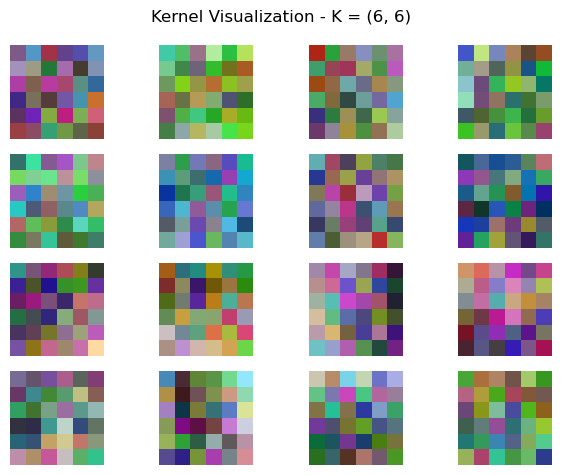

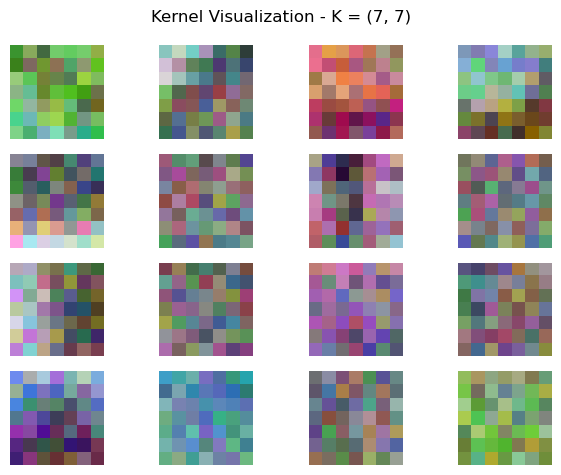

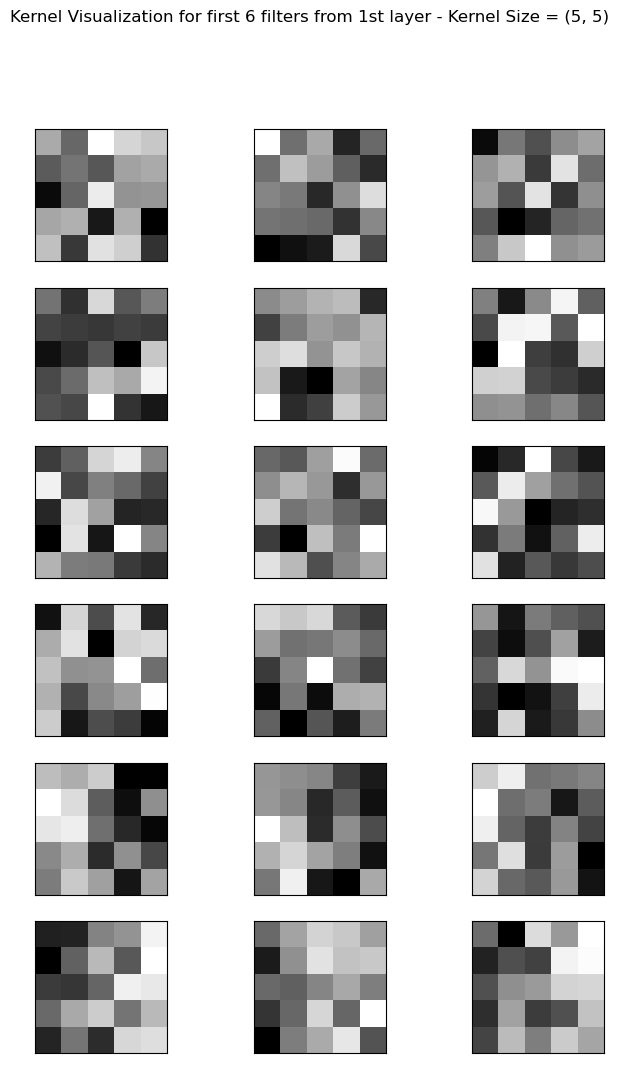

In [17]:
def visualize_kernel(weights, kernel_size):
        """
        This function visualizes the kernel
        :param weights:
        :param kernel_size:
        :return:
        """
        # Plot the kernels
        for i in range(weights.shape[-1]):
                plt.subplot(4, 4, i + 1)
                plt.imshow(weights[:, :, :, i].squeeze(), cmap='gray')
                plt.axis('off')
                plt.suptitle('Kernel Visualization - K = %s' % str(kernel_size))
        plt.tight_layout()
        # plt.savefig('kernel_visualization.png')
        plt.show()

for i in range(len(result)):
        visualize_kernel(result[i][4], result[i][0])


# For the kernel when K = 5
"""
We will be visualising the first six filters out of 16 filters from 1st layer, and plot each of the three channels of each filter. One row for each filter and one column for each channel.
"""
# plot first few filters
n_filters, ix = 6, 1
fig = plt.figure(figsize=(8, 12))
for i in range(n_filters):
    # get the filter
    f = result[2][4][:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # subplot for 6 filters and 3 channels
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# set the title of the figure
plt.suptitle('Kernel Visualization for first 6 filters from 1st layer - Kernel Size = %s' % str(result[2][0]))
# plot the filters
plt.show()



#### 3.4 Visualize the feature map

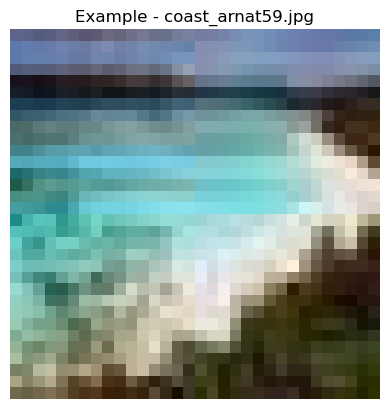

In [18]:


# load the image with the required shape
img = load_img('scene32/test/coast/coast_n203030.jpg', target_size=(32,32))
plt.imshow(img)
plt.title('Example - coast_arnat59.jpg')
plt.axis("off")
plt.show()

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)  #表示一张图片
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)


In [28]:
def visualize_feature_map(model, img, square):
        # get feature map
        feature_maps = model.predict(img)

        fig = plt.figure(figsize=(10,10))

        for i in range(1, square*square+1):
            # specify subplot and turn of axis
            ax = plt.subplot(square,square,i)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot feature maps in grayscale
            plt.imshow(feature_maps[0,:,:,i-1], cmap='gray')
        # plot all feature maps
        plt.show()

The following is the feature map for the first hidden layer(convolutional layer) of the model with kernel size (3,3) from Q1

1/1 [==============================] - 0s 69ms/step


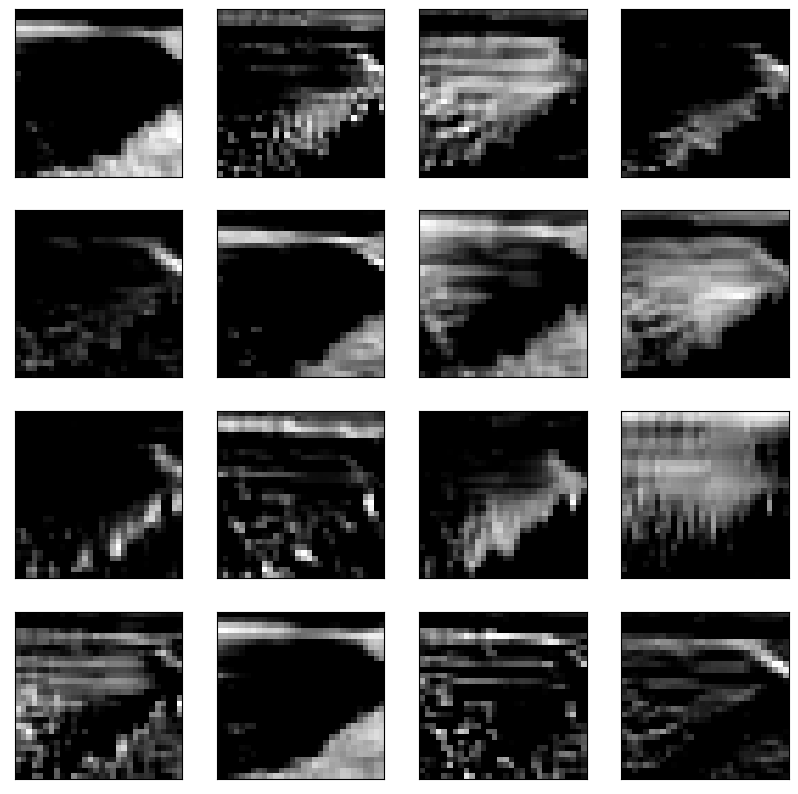

In [20]:
# get feature map for first hidden layer from Q1 model
# first convolutional layer
model = Model(inputs=classifier.model.inputs, outputs=classifier.model.layers[0].output)
visualize_feature_map(model, img, 4)

The following is the feature map for the **second** hidden layer(convolutional layer) of the model with kernel size (3,3) from **Q1**

1/1 [==============================] - 0s 56ms/step


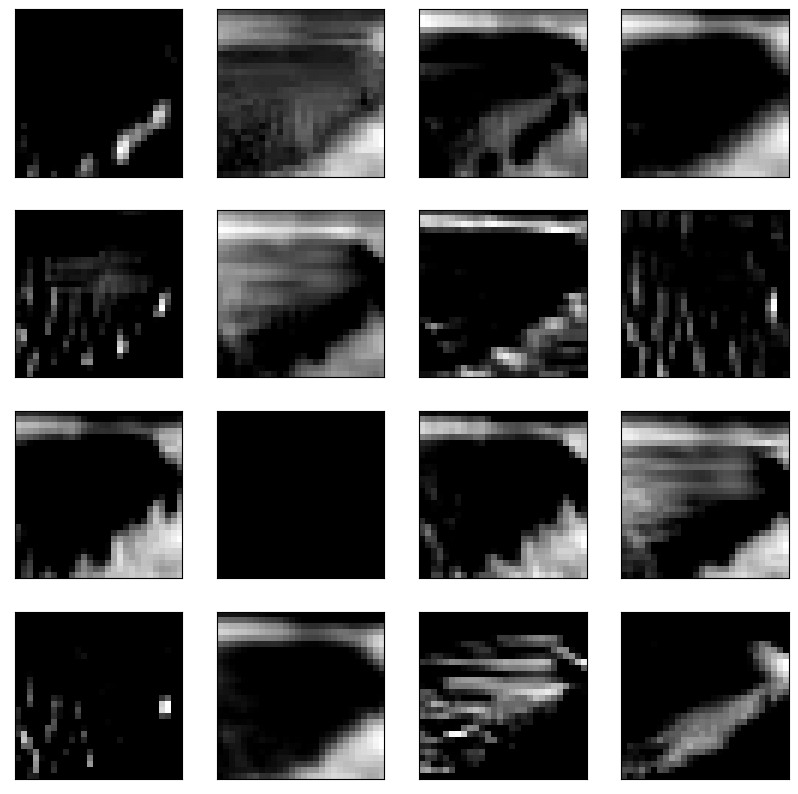

In [21]:
# second convolutional layer
model2 = Model(inputs=classifier.model.inputs, outputs=classifier.model.layers[1].output)
visualize_feature_map(model2, img, 4)

The following is the feature map for the **only** hidden layer(convolutional layer) of the model from **Q3**

For Kernel size = (3,3):

1/1 [==============================] - 0s 45ms/step


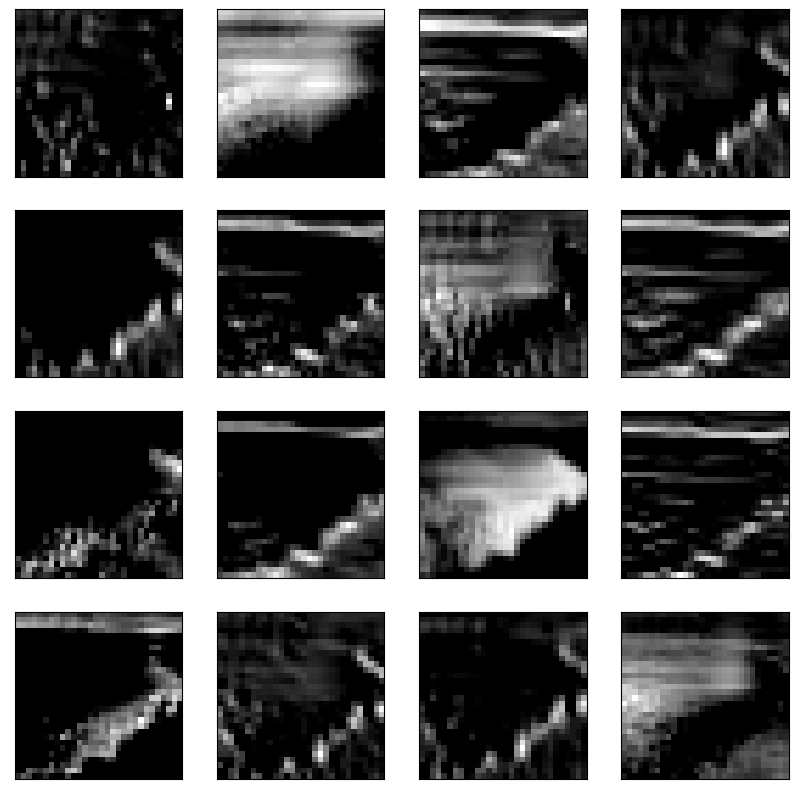

In [22]:
model3 = result[0][5]
visualize_feature_map(model3, img, 4)

For Kernel size = (5,5):

1/1 [==============================] - 0s 20ms/step


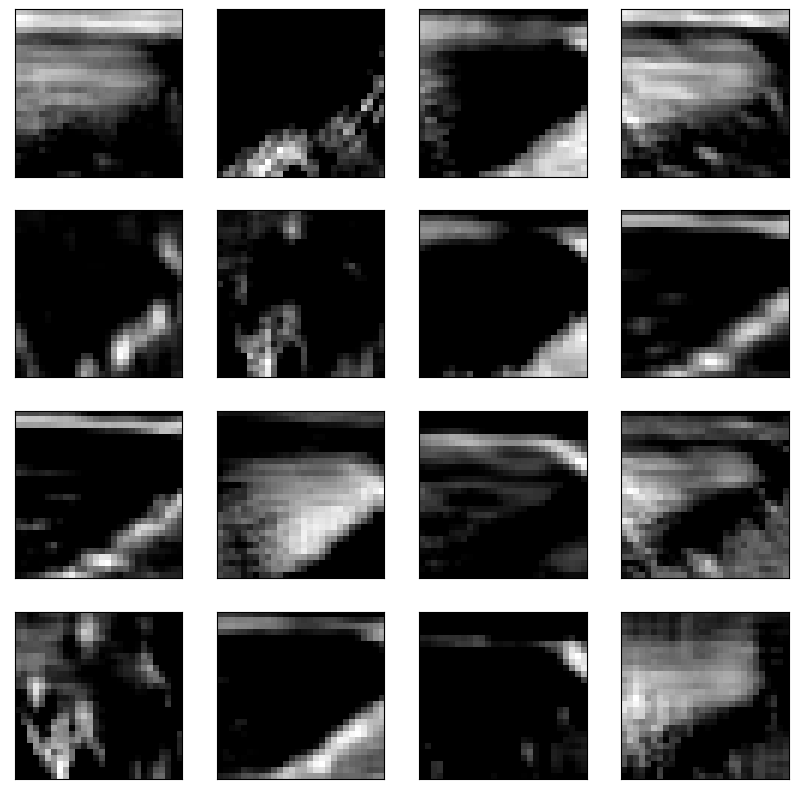

In [29]:
model3 = result[2][5]

visualize_feature_map(model3, img, 4)